# Navigation - Using Double-DQN With Dueling Network

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
# Imports.
import matplotlib.pyplot as plt
%matplotlib inline

# High-resolution plots for retina displays.
%config InlineBackend.figure_format = 'retina'

import os
import torch
import numpy as np
import time
import random

# Hide any deprecate warnings.
import warnings
warnings.filterwarnings("ignore")

# Utility imports.
from collections import deque
from unityagents import UnityEnvironment

# Agents interact with, and learns from environments.
from agent import Agent

# Please do not modify the line below.
env_path = "/data/Banana_Linux_NoVis/Banana.x86_64"
env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### Obtain NVidia GPU information

In [3]:
# Set the working device on the NVIDIA Tesla K80 accelerator GPU (depending on availability).
# Otherwise we use the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', str(device).upper())
print()

# Log additional info (when using the NVIDIA Tesla K80 accelerator).
# See <https://www.nvidia.com/en-gb/data-center/tesla-k80/>.
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: CUDA

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# Get the default brain.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# Reset the environment.
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents in the environment.
print('Number of agents:', len(env_info.agents))

# Number of actions.
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# Examine the state space.
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]  # Reset the environment.
state = env_info.vector_observations[0]            # Get the current state.
score = 0                                          # Initialize the score.
while True:
    action = np.random.randint(action_size)        # Select an action.
    env_info = env.step(action)[brain_name]        # Send the action to the environment.
    next_state = env_info.vector_observations[0]   # Get the next state.
    reward = env_info.rewards[0]                   # Get the reward.
    done = env_info.local_done[0]                  # See if episode has finished.
    score += reward                                # Update the score.
    state = next_state                             # Roll over the state to next time step.
    if done:                                       # Exit loop if episode finished.
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

#### Define the Training Function

In [7]:
""" Global configuration.
"""
TOGGLE_DOUBLE_DQN = True            # True for the Double-DQN method. False for the fixed Q-target method.
TOGGLE_DUELING_NETWORK = True       # True for the Dueling Network (DN) method.
TOGGLE_PRIORITIZED_REPLAY = False   # True for the Prioritized Replay memory buffer.

In [8]:
def dqn(n_episodes=int(2e3), max_t=int(1e3), eps_start=1., eps_end=1e-2, eps_decay=995e-3):
    """ Implementation of the Deep Q-Network (DQN) algorithm.
    
    Params
    ======
        n_episodes (int): Maximum number of training episodes
        max_t (int): Maximum number of timesteps per episode
        eps_start (float): Starting value of epsilon (ε), for epsilon-greedy action selection
        eps_end (float): Minimum value of epsilon (ε)
        eps_decay (float): Multiplicative factor (per episode, ε) for decreasing epsilon
    """
    
    # List containing scores from each episode.
    scores = []
    
    # List the mean of the window scores.
    scores_mean = []
    
    # Last 100 scores.
    scores_window = deque(maxlen=100)
    
    # Initialize epsilon (ε).
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # Send the action to the environment.
            next_state = env_info.vector_observations[0]   # Get the next state.
            reward = env_info.rewards[0]                   # Get the reward.
            done = env_info.local_done[0]                  # Gee if episode has finished.
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        # Save most recent score.
        scores.append(score)
        
        # Save most recent score.
        scores_window.append(score)
        scores_mean.append(np.mean(scores_window))
        
        # Log the scores.
        print('\rEPISODE {}\tAVG SCORE: {:.4f}\tEPS: {:.4f}\tLEARNING RATE: {}'
              .format(i_episode, scores_mean[-1], eps, agent.lr_scheduler.get_lr()), end="")
        
        # Decrease epsilon.
        eps = max(eps_end, eps_decay*eps)

        if i_episode % 100 == 0:
            print('\rEPISODE {}\tAVG SCORE: {:.4f}\tEPS: {:.4f}\tLEARNING RATE: {}'.format(
                i_episode, scores_mean[-1], eps, agent.lr_scheduler.get_lr()))
            
        if np.mean(scores_window) >= 13.:
            print('\n\nEnvironment solved in {:d} episodes.\nAverage score: {}.'.format(
                i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoint_double_dqn_dn.pth')
            print("Model saved successfully.")
            break
            
    # Return the scores.
    return scores, scores_mean

#### Create and Train the Agent

In [9]:
# Initialize a DQN agent instance.
agent = Agent(
    state_size=state_size, action_size=action_size, seed=0,
    double_dqn=TOGGLE_DOUBLE_DQN,
    dueling_network=TOGGLE_DUELING_NETWORK,
    prioritized_replay=TOGGLE_PRIORITIZED_REPLAY)

# Monitor training time (start time).
start_time = time.time()

# Now, we train the agent.
scores, mean = dqn(n_episodes=int(2e3), max_t=int(3e2), eps_start=1e-1, eps_end=1e-2, eps_decay=987e-3)

# Monitor training time (end time).
end_time = (time.time()-start_time)/6e1

# Log the runtime.
print("\nSolved in {:.2f} minutes.".format(end_time))

EPISODE 100	AVG SCORE: 10.3200	EPS: 0.0270	LEARNING RATE: [0.00022711322607504007]
EPISODE 158	AVG SCORE: 13.0600	EPS: 0.0128	LEARNING RATE: [0.00014699916918461692]

Environment solved in 58 episodes.
Average score: 13.06.
Model saved successfully.

Solved in 4.06 minutes.


#### Plot the Results

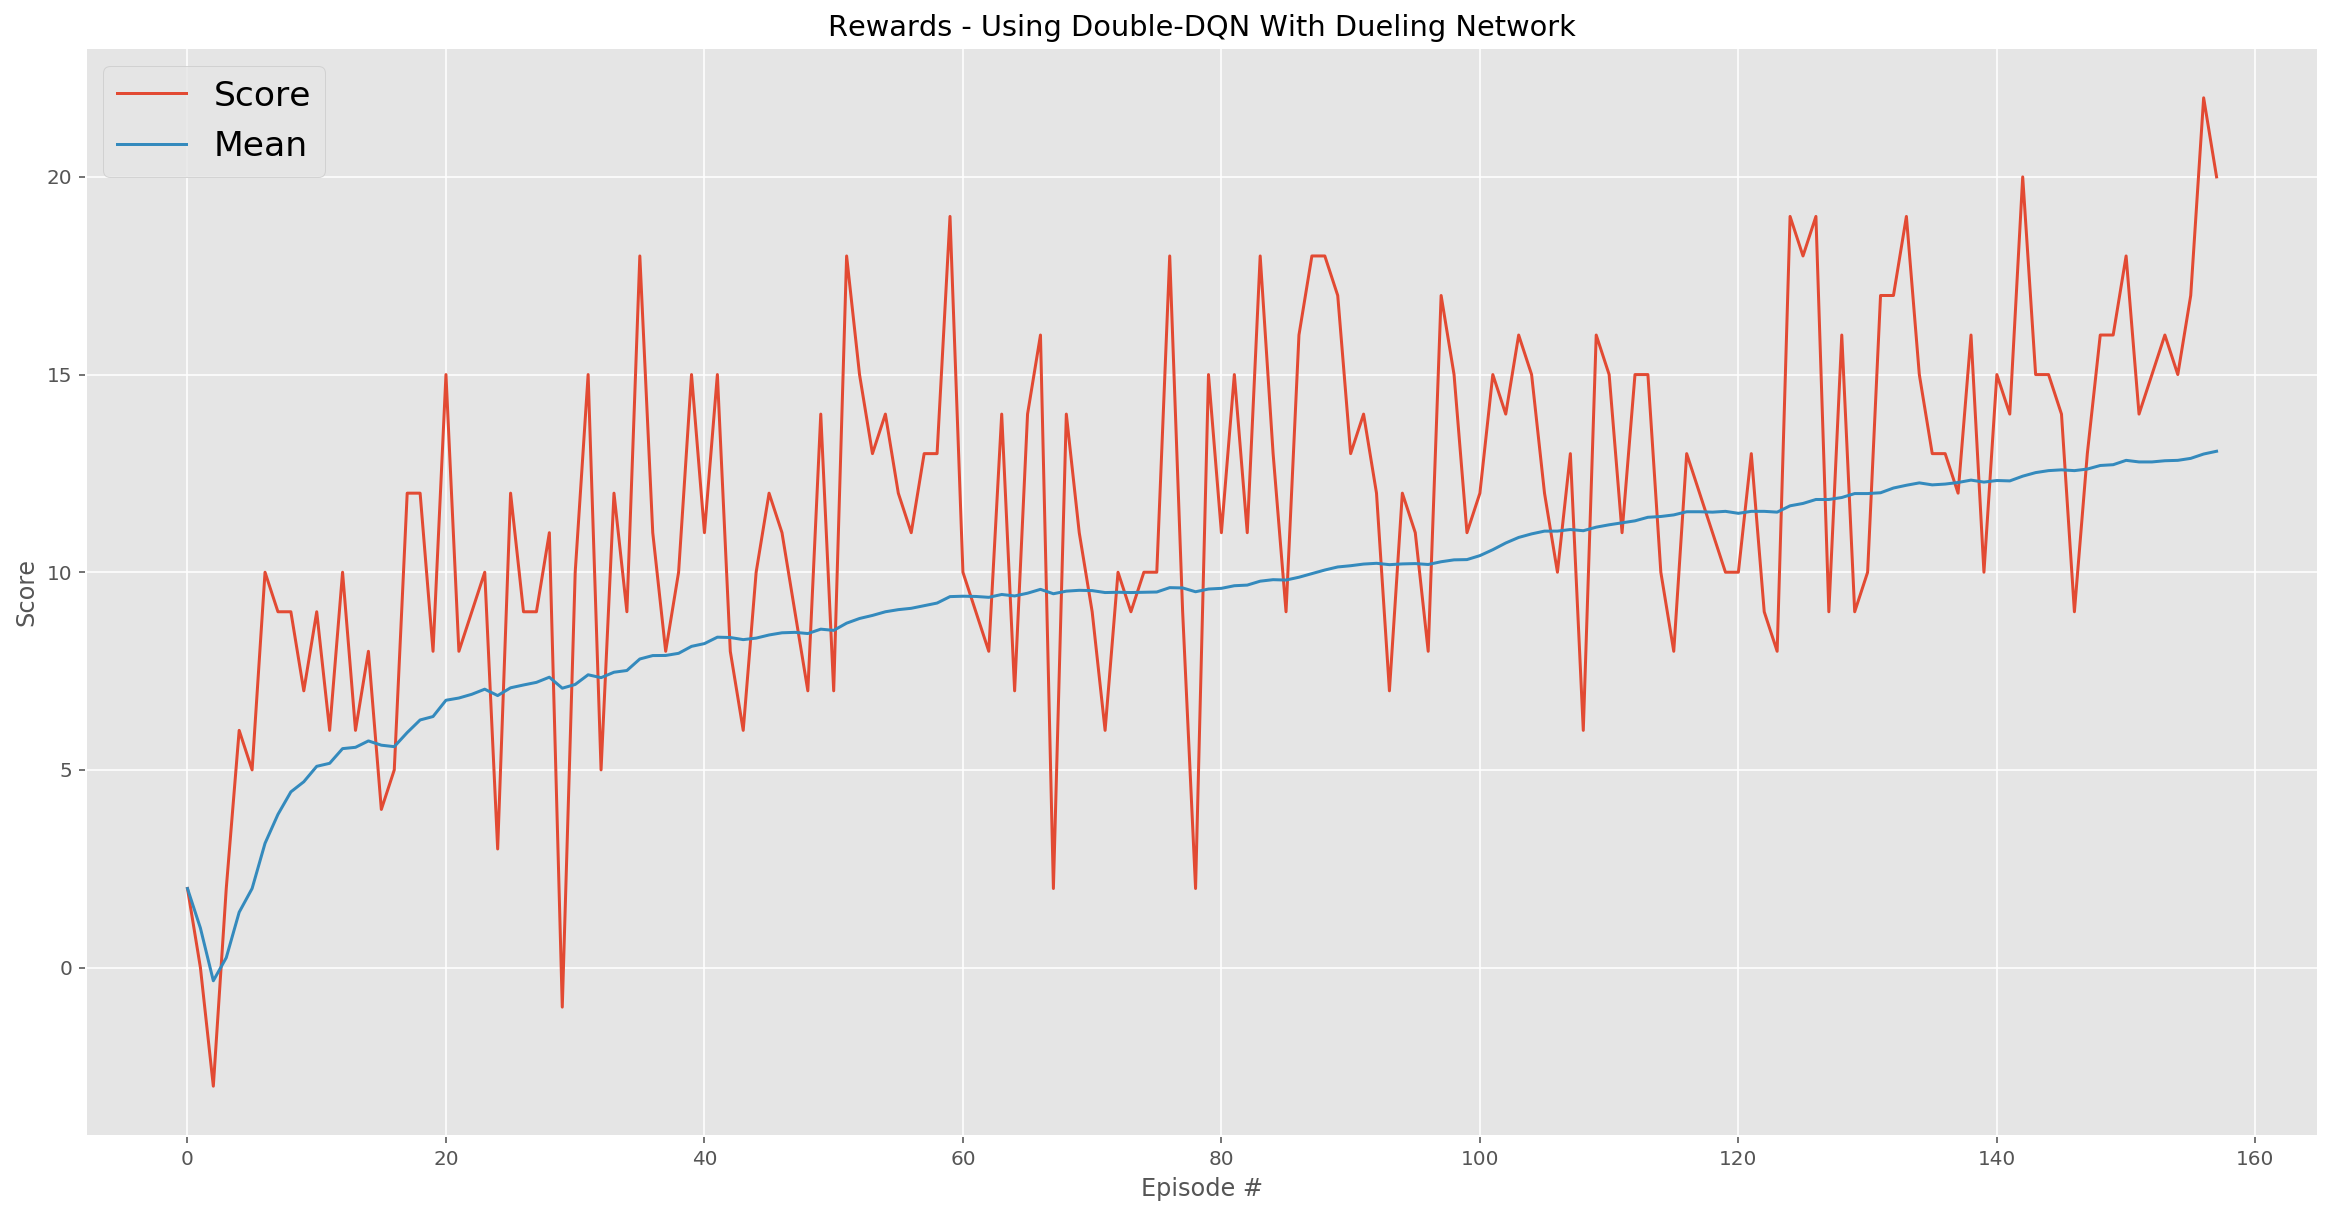

In [10]:
# Plot the scores using matplotlib.
plt.style.use('ggplot')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.title('Rewards - Using Double-DQN With Dueling Network')
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(mean)), mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Score', 'Mean'), fontsize='xx-large')

# Reveal the plot.
plt.show()

#### Reset the Environment

Now, we reset the environment and load the saved model (checkpoint) for further training.

In [11]:
try:
    env
except:
    env = UnityEnvironment(env_path) # Should be "/data/Banana_Linux_NoVis/Banana.x86_64".
    
    # Get the default brain.
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # Get the environment info (reusing code from above).
    env_info = env.reset(train_mode=False)[brain_name]

    # Number of actions.
    action_size = brain.vector_action_space_size

    # Examine the state space.
    state = env_info.vector_observations[0]
    state_size = len(state)

    # Initialize a DQN agent instanceins.
    agent = Agent(
        state_size=state_size, action_size=action_size, seed=0, lr_decay=9999e-4,
        double_dqn=TOGGLE_DOUBLE_DQN,
        dueling_network=TOGGLE_DUELING_NETWORK,
        prioritized_replay=TOGGLE_PRIORITIZED_REPLAY)

# Load the saved model (checkpoint).
state_dict = torch.load('models/checkpoint_double_dqn_dn.pth')
agent.qnetwork_local.load_state_dict(state_dict)
agent.qnetwork_local.eval()

# Try different parameters.
max_t = int(3e2)
n_episodes = 5 # 10.

# Monitor training time (start time).
start_time = time.time()

# List containing scores from each episode.
scores = []

# List the mean of the window scores.
scores_mean = []

for i_episode in range(1, n_episodes+1):
    state = env.reset(train_mode=False)[brain_name].vector_observations[0]
    score = 0
    for t in range(max_t):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # Send the action to the environment.
        next_state = env_info.vector_observations[0]   # Get the next state.
        reward = env_info.rewards[0]                   # Get the reward.
        done = env_info.local_done[0]                  # Gee if episode has finished.
        state = next_state
        score += reward
        print('\rEPISODE {}\tSCORE: {:.2f}'.format(i_episode, score), end="")
        if done:
            break 

    # Save most recent score.
    scores.append(score)

    # Save most recent score.
    scores_mean.append(np.mean(scores))
    
    # Log the current episode.
    print('\rEPISODE {}\tSCORE: {:.2f}'.format(i_episode, scores[-1]))

# Monitor training time (end time).
end_time = (time.time()-start_time)/6e1

# Log the runtime.
print("\nRuntime: {:.2f} minutes.".format(end_time))

EPISODE 1	SCORE: 18.00
EPISODE 2	SCORE: 18.00
EPISODE 3	SCORE: 9.00
EPISODE 4	SCORE: 13.00
EPISODE 5	SCORE: 9.00

Runtime: 2.49 minutes.


#### We're Finished!

When finished, you can close the environment.

In [12]:
env.close()